In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"

In [33]:
!ls ../img

bear.png	   input.bmp		 new_bg1.jpeg  sea_bg.jpeg
bear_tri.png	   jungle_bg.jpeg	 new_bg1.jpg   tri1.jpg
eq_refinement.png  lighthouse.bmp	 new_bg2.jpg   tri2.jpg
extracted.png	   lighthouse.png	 new_bg3.jpg   tri3.png
foggy.png	   lighthouse_tri.png	 new_bg3.png   trimap.bmp
img1.jpg	   matte.png		 new_bg.png
img2.jpg	   mean_multi_bg_eq.png  no_fog.png
img3.png	   multi_bg.png		 original.png


In [34]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'),0)

tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri1.jpg'),0)

print(img3.shape)
print(tri3.shape)

(1280, 1920, 3)
(1280, 1920)


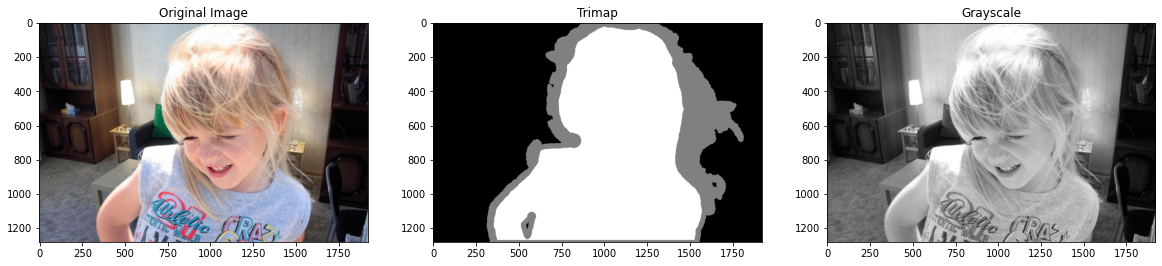

In [35]:
plt.figure(figsize = (20,15))

plt.subplot(131)
plt.imshow(img3)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(tri3,cmap='gray')
plt.title('Trimap')
plt.subplot(133)
plt.imshow(img3_gray,cmap='gray')
plt.title('Grayscale')


plt.show()

(1280, 1920, 3)


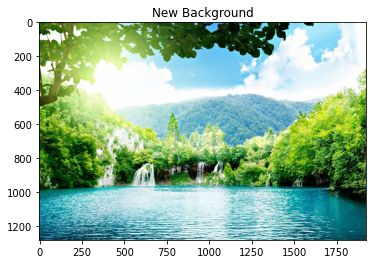

In [36]:
new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg1.jpg'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = cv2.resize(new_bg3, (img3.shape[1],img3.shape[0])) 
# new_bg3 = new_bg3[:img3.shape[0],:img3.shape[1],:]
print(new_bg3.shape)
plt.imshow(new_bg3)
plt.title('New Background')
plt.show()

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



In [37]:
mask_bg = (tri3<10)
mask_fg = (tri3>245)
mask_unknown = (np.bitwise_and(tri3>=10,tri3<=245))

fg = img3_gray*(mask_fg)
bg = img3_gray*(mask_bg)
unknown = img3_gray*mask_unknown

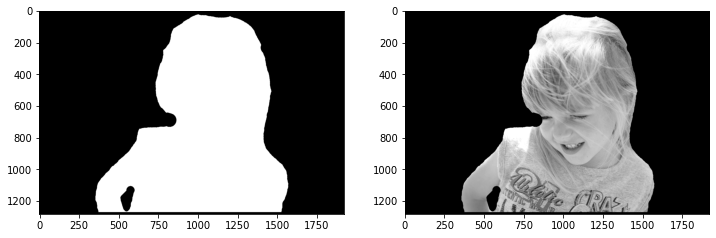

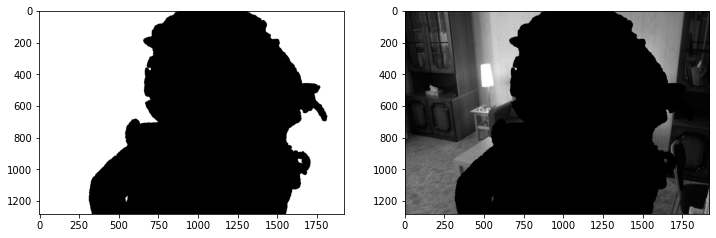

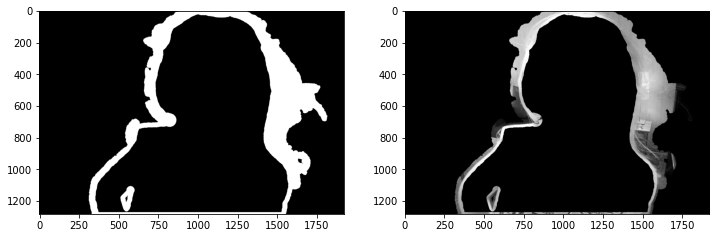

In [38]:
plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_fg,cmap='gray')
plt.subplot(222)
plt.imshow(fg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_bg,cmap='gray')
plt.subplot(222)
plt.imshow(bg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_unknown,cmap='gray')
plt.subplot(222)
plt.imshow(unknown,cmap='gray')
plt.show()

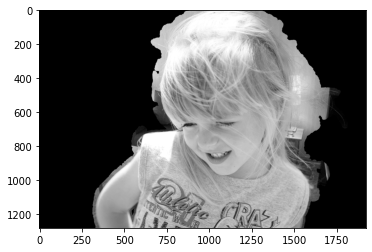

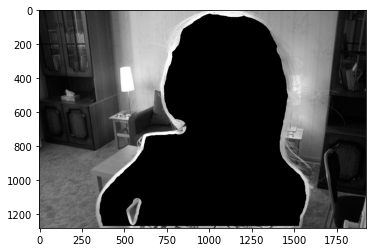

In [39]:
F = img3_gray*(mask_fg+mask_unknown)
B = img3_gray*(mask_bg+mask_unknown)

diff = np.minimum(np.maximum(F-B,0),255)

diff = ndimage.filters.gaussian_filter(diff, 0.9)
diff = np.minimum(np.maximum(diff,0),255)

plt.imshow(F,cmap='gray')
plt.show()
plt.imshow(B,cmap='gray')
plt.show()
# IF possible add a personal Gaussian filter in the next line
# diff = cv2.GaussianBlur(diff,(5,5),cv2.BORDER_DEFAULT)

In [40]:
grad_y,grad_x = np.gradient(img3_gray)
diff[diff==0] = 1
d2y_alpha, _ = np.gradient(grad_y/diff)
_, d2x_alpha = np.gradient(grad_x/diff)

In [41]:
d2alpha = d2y_alpha + d2x_alpha

In [42]:
estimate_alpha = mask_fg + 0.5*mask_unknown

##  Computationally efficient version of Global alpha matting

In [59]:
def optimal_alpha_matting(alpha, d2alpha, unknown):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(alpha.shape)
    h, w = img3_gray.shape
    threshold = 0.001
    iters = 50
    non_zero = np.nonzero(unknown)
    c_alpha = np.transpose(non_zero)
    c = c_alpha[(c_alpha[:,0]>=1)&(c_alpha[:,0]<h-1)&(c_alpha[:,1]>=1)&(c_alpha[:,1]<w-1)]
    first = c[:,0]
    second = c[:,1]
    diff = np.sum(np.abs(new_alpha - old_alpha))
    for i in range(iters):
        old_alpha = new_alpha.copy()
        new_alpha[first,second] = new_alpha[first-1 ,second]
        new_alpha[first,second] = new_alpha[first,second] 
        new_alpha[first,second] += new_alpha[first,second-1]
        new_alpha[first,second] += old_alpha[first, second+1] 
        new_alpha[first,second] += old_alpha[first+1,second]
        new_alpha[first,second] -= d2alpha[first,second]
        new_alpha[first,second] *= 1/4
        diff = np.sum(np.abs(new_alpha - old_alpha))
        if(diff < threshold):
            break
    return new_alpha

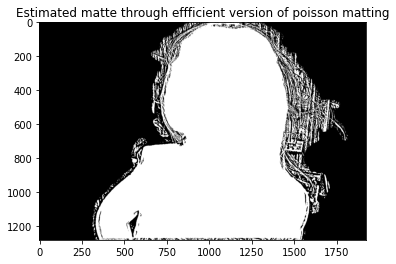

In [61]:
alpha = optimal_alpha_matting(alpha, d2alpha, mask_unknown)
alpha = np.minimum(np.maximum(alpha,0),1)

plt.imshow(alpha,cmap='gray')
plt.title('Estimated matte through effficient version of poisson matting')
plt.show()

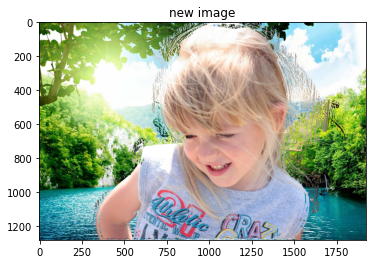

In [62]:
# alpha blending
new_img = np.zeros(new_bg3.shape)
new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.title('new image')
plt.show()

In [63]:
def convolve(img,kernel):
    h,w = img.shape
    k_h,k_w = kernel.shape
    
    output = np.zeros([h,w])
    
    padding_img = np.zeros([h+k_h-1,w+k_w-1])
    padding_img[int((k_h-1)/2):int(h+(k_h-1)/2),int((k_w-1)/2):int(w+(k_w-1)/2)] = img
    
    for i in range(k_h,h+k_h):
        for j in range(k_w,w+k_w):
            area_obs = padding_img[i-k_h:i,j-k_w:j]
            val = sum(sum(kernel*area_obs))
            output[i-k_h,j-k_w] = max(0,val)

    
    return np.int64(output)

In [68]:
def highboost(alpha,img,F,B,unknown_seg):
    
    k = 5
    
    gaussian_kernel = np.zeros([k,k])
    
    center = int((k-1)/2)
    sigma_s = 5
    
    for i in range(k):
        for j in range(k):
            gaussian_kernel[i][j] = np.exp(-(((i - center)**2 + (j-center)**2) / (2 * sigma_s * sigma_s)))
    
    grad_y,grad_x = np.gradient(img)
    
    D_y = convolve(grad_y,gaussian_kernel)
    D_x = convolve(grad_x,gaussian_kernel)
    
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)

    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient((grad_y-D_y)/diff)
    _, d2x_alpha = np.gradient((grad_x-D_x)/diff)

    alpha = optimal_alpha_matting(alpha, d2alpha, unknown_seg)
    alpha = np.minimum(np.maximum(alpha,0),1)
    
    return alpha
    

In [69]:
high_pass_alpha = highboost(estimate_alpha,img3_gray,F,B,mask_unknown)

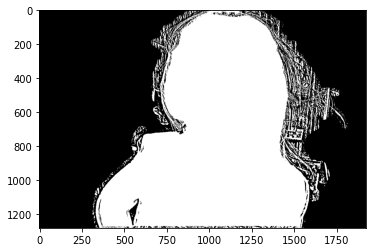

In [70]:
plt.imshow(high_pass_alpha,cmap='gray')
# plt.title('Estimated matte through effficient version of poisson matting')
plt.show()

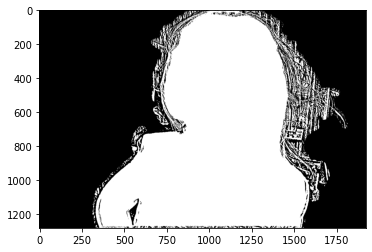

In [71]:
plt.imshow(alpha,cmap='gray')
# plt.title('Estimated matte through effficient version of poisson matting')
plt.show()